# Инфириенс

In [68]:
import numpy as np
import pandas as pd
import os
import json
from PIL import Image
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import seaborn as sns
import random
import cv2
# from pycocotools.coco import COCO
import time

import warnings
warnings.filterwarnings('ignore')

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms


import torchvision.models as models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from torchvision.models import mobilenet_v3_large
import torch.nn as nn
from torch.nn import functional as F

In [69]:
device_id = -1
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'

classes = 2
classes1 = 156
device

'cpu'

In [70]:
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection import FasterRCNN

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
modeld1 = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler).to(device)
checkpoint1 = torch.load('./detect9/chkpt_model1_d_5.pth', map_location=device)
modeld1.load_state_dict(checkpoint1['model_state_dict'])

<All keys matched successfully>

In [71]:
transform = transforms.Compose([transforms.ToTensor(),])

In [96]:
img_path = '.'
img_name = '56.jpg'
detection_threshold = 0.2
image1 = Image.open(img_name)

In [97]:
modeld1.eval()
image = transform(image1).to(device)
image = image.unsqueeze(0) # add a batch dimension
outputs = modeld1(image)
pred_classes = [i for i in outputs[0]['labels'].cpu().numpy()]
    # get score for all the predicted objects
pred_scores = outputs[0]['scores'].detach().cpu().numpy()
    # get all the predicted bounding boxes
pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()
    # get boxes above the threshold score
boxes = pred_bboxes[pred_scores >= detection_threshold].astype(np.int32)
pred_scores

array([0.991456  , 0.8376362 , 0.212114  , 0.12947813, 0.10696121,
       0.10531152, 0.07097223, 0.05045314], dtype=float32)

In [98]:
boxes

array([[ 109,  588,  143,  623],
       [ 697,  579,  729,  610],
       [ 955,    7, 1047,  120]])

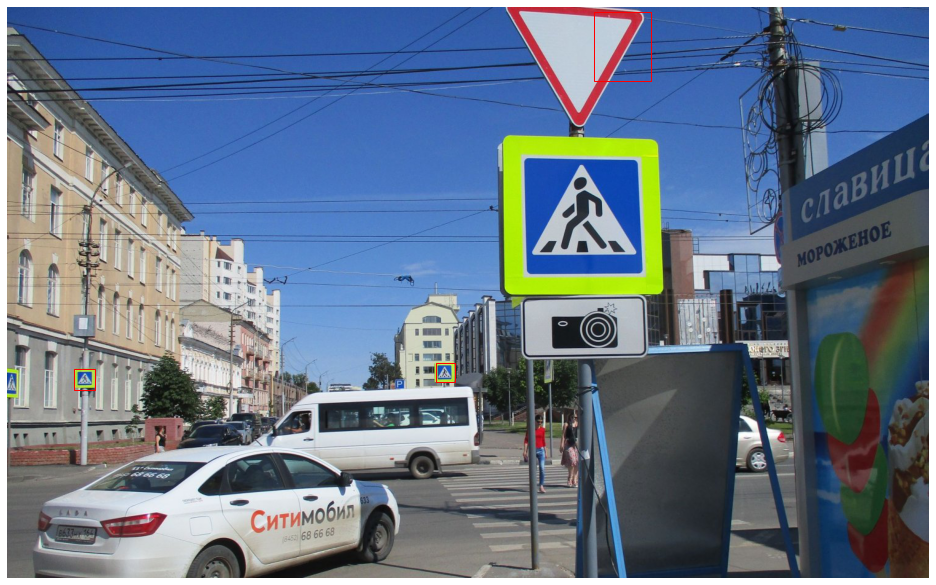

In [99]:
im = Image.open(img_name)

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.imshow(im)
for i in range(len(boxes)):
    rect = patches.Rectangle((boxes[i][0], boxes[i][1]), boxes[i][2] - boxes[i][0], boxes[i][3] - boxes[i][1], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
plt.axis('off')
plt.show()

In [100]:
class ResidualBlock(nn.Module):
    """
    Creates the Residual block of ResNet.
    """
    def __init__(
        self, in_channels, out_channels, use_1x1conv=True, strides=1
    ):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(out_channels, out_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(in_channels, out_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
    def forward(self, x):
        inputs = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        if self.conv3:
            inputs = self.conv3(inputs)
        x += inputs
        return F.relu(x)

In [101]:
def create_resnet_block(
    input_channels,
    output_channels, 
    num_residuals,
):
        resnet_block = []
        for i in range(num_residuals):
            if i == 0:
                resnet_block.append(ResidualBlock(input_channels, output_channels,
                                    use_1x1conv=True, strides=2))
            else:
                resnet_block.append(ResidualBlock(output_channels, output_channels))
        return resnet_block 

In [102]:
class CustomResNet(nn.Module):
    def __init__(self, num_classes=157):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(16), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.block2 = nn.Sequential(*create_resnet_block(16, 32, 2))
        self.block3 = nn.Sequential(*create_resnet_block(32, 64, 2))
        self.block4 = nn.Sequential(*create_resnet_block(64, 128, 2))
        self.block5 = nn.Sequential(*create_resnet_block(128, 256, 2))
        self.linear = nn.Linear(256, num_classes)
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        bs, _, _, _ = x.shape
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        x = self.linear(x)
        return x 

In [103]:
model_c = CustomResNet()
checkpoint = torch.load('./clf9/chkpt_m1c_clf_8.pth', map_location=device)
model_c.load_state_dict(checkpoint)#['model_state_dict'])

<All keys matched successfully>

In [104]:
boxes

array([[ 109,  588,  143,  623],
       [ 697,  579,  729,  610],
       [ 955,    7, 1047,  120]])

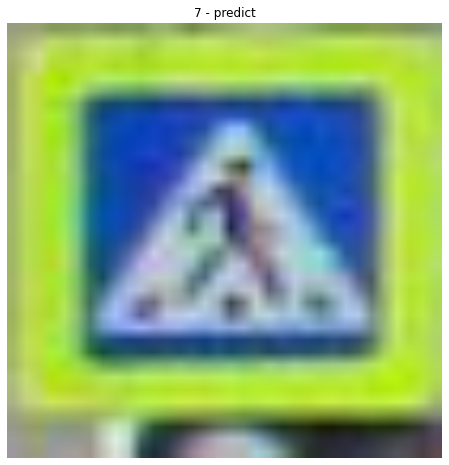

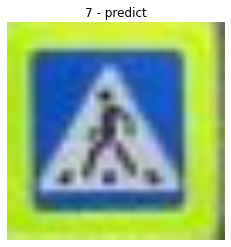

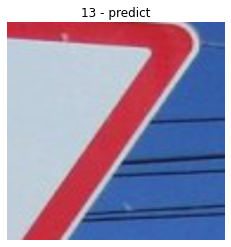

In [107]:
from torchvision.transforms import functional as func

figure = plt.figure(figsize=(10, 8))
for i in range(len(boxes)):
    im = Image.open(img_name)
    coordinates = [boxes[i][0], boxes[i][1],
                    boxes[i][2], boxes[i][3]]
    cropped = im.crop(coordinates)
    cropped =  func.resize(cropped, [512,512])
    image = transform(cropped).to(device)
    image = image / 255
    image = image.unsqueeze(0)
    predict = torch.argmax(model_c(image)).detach().cpu().numpy()
    plt.imshow(cropped)
    plt.title('{} - predict'.format(predict))
    plt.axis("off")
    plt.show()

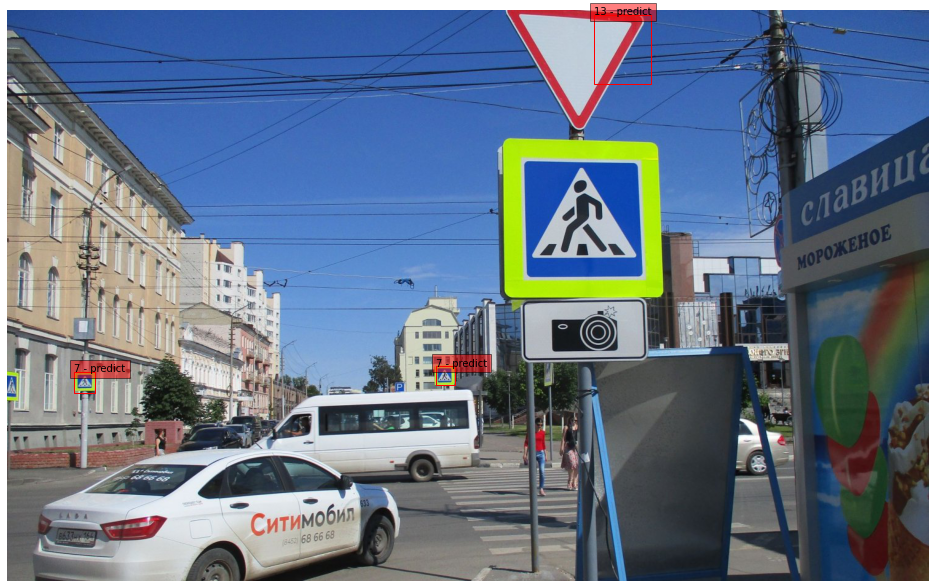

In [108]:
im = Image.open(img_name)

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.imshow(im)
for i in range(len(boxes)):
    rect = patches.Rectangle((boxes[i][0], boxes[i][1]), boxes[i][2] - boxes[i][0], boxes[i][3] - boxes[i][1], linewidth=1, edgecolor='r', facecolor='none')
    coordinates = [boxes[i][0], boxes[i][1], boxes[i][2], boxes[i][3]]
    cropped = im.crop(coordinates)
    cropped =  func.resize(cropped, [512,512])
    image = transform(cropped).to(device)
    image = image / 255
    image = image.unsqueeze(0)
    predict = torch.argmax(model_c(image)).detach().cpu().numpy()
    ax.add_patch(rect)
    plt.text(boxes[i][0], boxes[i][1], '{} - predict'.format(predict), bbox=dict(facecolor='red', alpha=0.5))
    
plt.axis('off')
plt.show()

In [45]:
def distance_to_camera(knownWidth, focalLength, perWidth):
# compute and return the distance from the maker to the camera
       return (knownWidth * focalLength) / perWidth

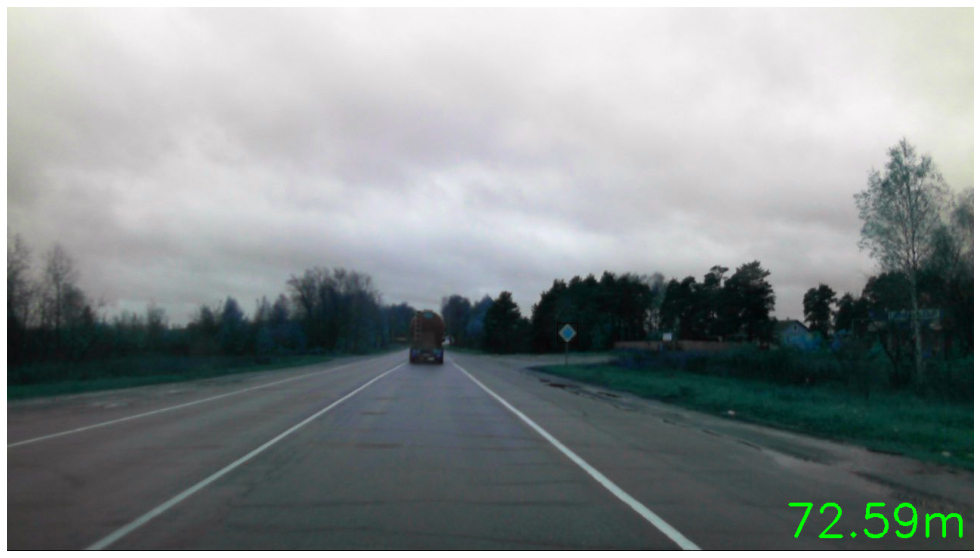

In [69]:
fig = plt.figure(figsize=(18, 10))
r3 = np.random.choice(df_val.file_name)
q = cv2.imread('./' + r3, 1)
im_labels = df_val[df_val.file_name == r3].iloc[0]

inches = distance_to_camera(700, 28, im_labels.bbox[2])

plt.imshow(q)

rect = cv2.rectangle(q,(im_labels.bbox[0], im_labels.bbox[1]), 
                     (im_labels.bbox[0]+im_labels.bbox[2], im_labels.bbox[1]+im_labels.bbox[3]), 15)


cv2.putText(q, "%.2fm" % ((inches)/10),
        (q.shape[1] - 250, q.shape[0] - 20), cv2.FONT_HERSHEY_SIMPLEX,
        2.0, (0, 255, 0), 3)

plt.imshow(rect)
plt.axis("off")
plt.show() 